# PORTFOLIO SIMULATION - MONTECARLO WITH MEAN AND STD

In [149]:
import pandas as pd
import numpy as np

In [151]:
# given the mean and the std of a normal distribution, calculate montecarlo simulations for horizons 60,120,180,240, and return a DataFrame with the data
def generate_montecarlo_from_normal(mean, std, n_simulations=1000):
    # rendimento mensilizzato
    mean = (1 + mean) ** (1/12) - 1  # convert annual to monthly
    std = std / np.sqrt(12)  # convert annual std to monthly std
    horizons = [60, 120, 180, 240, 360]
    results = {horizon: [] for horizon in horizons}

    for horizon in horizons:
        # Simula i rendimenti per ogni orizzonte temporale e crea un dataframe per ogni simulazione
        for _ in range(n_simulations):
            # Genera rendimenti normali per l'orizzonte specificato
            simulated_returns = np.random.normal(loc=mean, scale=std, size=horizon)
            # Calcola il rendimento cumulativo
            results[horizon].append(pd.DataFrame(simulated_returns))

    return results

normal_portfolios = generate_montecarlo_from_normal(0.0848, 0.0898, n_simulations=10000)


In [152]:
# for each simulation calculate the cumulative returns
def calculate_cumulative_returns(simulations):
    cumulative_returns = {}
    for horizon, sim_list in simulations.items():
        cum_returns = []
        for sim in sim_list:
            cum_return = (1 + sim).cumprod() - 1  # Calcola i rendimenti cumulativi
            cum_returns.append(cum_return)
        cumulative_returns[horizon] = cum_returns
    return cumulative_returns

def analyze_simulations(simulations):
    final_returns_list = []
    variances_list = []

    for sim in simulations:
        # Calcolo del rendimento cumulativo per ogni asset (log → somma, altrimenti moltiplica)
        cumulative = (1 + sim).sum() - 1  # se usi pct_change; usa .sum() se hai log-returns
        variance = sim.std()  # varianza su tutti i mesi

        final_returns_list.append(cumulative)
        variances_list.append(variance)

    # Combina i risultati in DataFrame
    final_returns_df = pd.DataFrame(final_returns_list)
    variances_df = pd.DataFrame(variances_list)

    # Rendimento medio finale e varianza media su tutte le simulazioni
    mean_final_return = final_returns_df.mean()
    mean_variance = variances_df.mean()

    return mean_final_return, mean_variance

def max_drawdown(rets_df, initial_value=100):
    # 1. Calcola indice di ricchezza cumulato (wealth index)
    wealth = (1 + rets_df).cumprod() * initial_value

    # 2. Calcola picco cumulativo (running max)
    running_max = wealth.cummax()

    # 3. Calcola drawdown in ogni istante
    drawdown = wealth / running_max - 1

    # 4. Massimo drawdown (più negativo) per asset
    mdd = drawdown.min()

    return mdd


def summarize_simulations(simulations, months, use_log_returns=False):
    final_returns = []
    variances = []
    max_drawdowns = []

    for sim in simulations:
        if use_log_returns:
            cumulative_return = np.exp(sim.sum()) - 1
        else:
            cumulative_return = (1 + sim).prod() - 1

        variance = sim.std()

        ## annualizza il rendimento cumulativo e la varianza
        cumulative_return_annualized = (1 + cumulative_return) ** (12 / months) - 1
        variance_annualized = variance
        mdd = max_drawdown(sim)

        final_returns.append(cumulative_return_annualized)
        variances.append(variance_annualized)
        max_drawdowns.append(mdd)

    # Costruisci i DataFrame
    final_returns_df = pd.DataFrame(final_returns)    # ogni riga = 1 simulazione
    variances_df = pd.DataFrame(variances)
    max_drawdowns_df = pd.DataFrame(max_drawdowns)

    return final_returns_df, variances_df, max_drawdowns_df

def horizon_summary(montecarlo_simulations, horizon_list=[60, 120, 180, 240, 360], use_log_returns=False):
    rows = []

    for horizon in horizon_list:
        ret_df, var_df, mdd_df = summarize_simulations(montecarlo_simulations[horizon], horizon, use_log_returns=use_log_returns)

        # Calcola il ritorno finale
        final_df = (1 + ret_df) ** (horizon / 12) - 1

        for sigma in [0.025, 0.15, 0.5, 0.7, 0.95]:
            # find the index of the simulation that corresponds to the sigma quantile
            # Calcola il quantile su ret_df
            quantile_value = ret_df.quantile(sigma).item()  # ottieni lo scalare

            # Trova l'indice della riga più vicina
            closest_index = (ret_df.iloc[:, 0] - quantile_value).abs().idxmin()


            # usa questo indice per ottenere i dati di final, variance e mdd


            summary = {
                "horizon_sigma": f"{horizon}_{sigma}",
                "return": ret_df.loc[closest_index].item(),
                "final": final_df.loc[closest_index].item(),
                "variance": var_df.loc[closest_index].item(),
                "mdd": mdd_df.loc[closest_index].item()
            }

            rows.append(summary)

    # Crea il DataFrame finale
    tot_summary = pd.DataFrame(rows).set_index("horizon_sigma")

    return tot_summary

summ_normal = horizon_summary(normal_portfolios, use_log_returns= False)
summ_normal

,return,final,variance,mdd
horizon_sigma,,,,
60_0.025,-0.001210,-0.006034,0.028024,-0.289363
60_0.15,0.035473,0.190404,0.024133,-0.113253
60_0.5,0.081336,0.478438,0.028853,-0.133686
60_0.7,0.104750,0.645582,0.026466,-0.106435
60_0.95,0.154187,1.048237,0.019572,-0.046241
120_0.025,0.022883,0.253890,0.026026,-0.152072
120_0.15,0.049557,0.622041,0.021730,-0.167384
120_0.5,0.080534,1.169630,0.023779,-0.095077
120_0.7,0.096431,1.510799,0.024532,-0.082847


# Portfolio Simulation - Montecarlo WITH Bootstrap

In [153]:
portfolios_weights = [
    {"name": "MSCI-World", "composition": [("msci-world", 1)]},
    {"name": "60-40", "composition": [("msci-world", 0.6), ("bond-7-10", 0.4)]},
    {"name": "All-Weather World", "composition": [("msci-world", 0.6), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "All-Weather + EIMI", "composition": [("msci-world", 0.5), ("msci-world-em",0.1), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1)]},
    {"name": "Factors - No Bond", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.35), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors + Cash", "composition": [("msci-world-momentum", 0.35),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]}
]
import pandas as pd
import os
from functools import reduce

def load_asset_data(assets, path="data/csv"):
    asset_data = {}
    for asset in assets:
        file_path = os.path.join(path, f"{asset}.csv")
        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
        df = df.sort_index()
        df = df[df.columns[0]]
        asset_data[asset] = df.rename(asset)
    return asset_data

def align_assets(asset_data):
    return reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="inner"),
                  asset_data.values())

def compute_monthly_returns(prices_df, log_returns=False):
    if log_returns:
        return np.log(prices_df / prices_df.shift(1)).dropna()
    else:
        return prices_df.pct_change().dropna()


def construct_portfolios(portfolios, asset_returns):
    portfolio_returns = {}

    for portfolio in portfolios:
        name = portfolio["name"]
        composition = portfolio["composition"]

        weights = {asset: weight for asset, weight in composition}

        # check if the sum of the weights is 1
        if not np.isclose(sum(weights.values()), 1.0):
            raise ValueError(f"Weights for portfolio '{name}' do not sum to 1.0")

        df = pd.DataFrame()
        for asset, weight in weights.items():
            df[asset] = asset_returns[asset] * weight

        portfolio_returns[name] = df.sum(axis=1)

    return pd.DataFrame(portfolio_returns)

def prepare_portfolios(portfolios_weights, data_path="data/csv", log_returns=False):
    all_assets = sorted(set(asset for p in portfolios_weights for asset, _ in p["composition"]))
    asset_data = load_asset_data(all_assets, path=data_path)
    aligned_prices = align_assets(asset_data)
    aligned_returns = compute_monthly_returns(aligned_prices, log_returns=log_returns)
    portfolio_returns = construct_portfolios(portfolios_weights, aligned_returns)
    return portfolio_returns, aligned_returns

portfolio_returns, asset_returns = prepare_portfolios(portfolios_weights)


In [154]:
def portfolio_statistics(returns, periods_per_year=12):
    stats = pd.DataFrame(index=returns.columns)

    # 1. Rendimento annualizzato (media geometrica)
    stats["annualized_return"] = (1 + returns.mean()) ** periods_per_year - 1

    # 2. Volatilità annualizzata
    stats["annualized_volatility"] = returns.std() * np.sqrt(periods_per_year)

    # 3. Maximum Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = cum_returns / peak - 1
    stats["max_drawdown"] = drawdown.min()

    return stats
portfolio_stats = portfolio_statistics(portfolio_returns)
print(portfolio_stats)




                    annualized_return  annualized_volatility  max_drawdown
MSCI-World                   0.092772               0.138525     -0.487969
60-40                        0.069769               0.088298     -0.279779
All-Weather World            0.074850               0.085135     -0.266294
All-Weather + EIMI           0.071939               0.084543     -0.277971
Factors                      0.090735               0.090399     -0.275959
Factors - No Bond            0.092560               0.097943     -0.325160
Factors + Cash               0.079871               0.077232     -0.226424


In [155]:
def montecarlo_bootstrap(returns, n_simulations=1000, horizon_months=120, log_returns=False, seed=None):
    """
    Simula traiettorie future con bootstrap dei rendimenti storici.
    
    returns: Series (es. un portafoglio)
    log_returns: True = usa somma log, False = usa compounding semplice
    """
    if seed:
        np.random.seed(seed)
        
    returns = returns.dropna().values
    n_obs = len(returns)

    simulations = []

    for _ in range(n_simulations):
        sampled = np.random.choice(returns, size=horizon_months, replace=True)
        
        if log_returns:
            cumulative = np.exp(np.cumsum(sampled))  # da log-rendimenti a valore relativo
        else:
            cumulative = np.cumprod(1 + sampled)

        simulations.append(cumulative)

    return pd.DataFrame(simulations).T  # colonne = simulazioni, righe = mesi

def run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], 
                                   n_simulations=1000, log_returns=False):
    simulations = {}

    for portfolio in portfolio_returns.columns:
        portfolio_simulations = {}
        for h in horizons:
            sim_df = montecarlo_bootstrap(portfolio_returns[portfolio], horizon_months=h,
                                          n_simulations=n_simulations, log_returns=log_returns)
            portfolio_simulations[h] = sim_df
        simulations[portfolio] = portfolio_simulations

    return simulations

simulations = run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], n_simulations=1000)


In [156]:
def calc_max_recovery_time(series):
    peak = series.cummax()
    in_drawdown = series < peak

    recovery_times = []
    count = 0
    for down in in_drawdown:
        if down:
            count += 1
        else:
            if count > 0:
                recovery_times.append(count)
            count = 0
    if count > 0:
        recovery_times.append(count)

    return max(recovery_times) if recovery_times else 0


def summarize_simulations(sim_df, horizon_months):
    """
    sim_df: DataFrame con simulazioni (righe = mesi, colonne = simulazioni)
    """
    final_vals = sim_df.iloc[-1]
    ann_returns = final_vals ** (12 / horizon_months) - 1

    stats = {}

    for q in ["mean", 0.0, 0.025]:
        if q == "mean":
            col = ann_returns.mean()
            # prendi la colonna più vicina alla media
            sim_id = (ann_returns - col).abs().idxmin()
        else:
            target = ann_returns.quantile(q)
            sim_id = (ann_returns - target).abs().idxmin()

        sim = sim_df[sim_id]

        # Ritorno annualizzato (già calcolato sopra)
        final_val = sim.iloc[-1]
        ann_return = final_val ** (12 / horizon_months) - 1

        # Std annualizzata
        monthly_ret = sim.pct_change().dropna()
        ann_std = monthly_ret.std() * np.sqrt(12)

        # Maximum Drawdown
        cum = sim
        peak = cum.cummax()
        dd = (cum / peak - 1).min()

        recovery_times = [calc_max_recovery_time(sim_df[col]) for col in sim_df.columns]
        # compute the mean of the recovery times
        recovery_time = np.mean(recovery_times) if q == "mean" else calc_max_recovery_time(sim)

        stats[str(q)] = {
            "return": ann_return,
            "std": ann_std,
            "mdd": dd,
            "recovery_time": recovery_time
        }
    # compute the 0.05 quantile of the MDD
    all_mdds = []

    for col in sim_df.columns:
        sim = sim_df[col]
        peak = sim.cummax()
        dd = (sim / peak - 1).min()
        all_mdds.append(dd)

    stats["max_mdd_0.05"] = {
        "return": np.nan,
        "std": np.nan,
        "mdd": pd.Series(all_mdds).quantile(0.0)
    }


    return pd.DataFrame(stats).T

def summarize_all(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            stats_df["portfolio"] = portfolio
            stats_df["horizon"] = h
            stats_df["quantile"] = stats_df.index
            records.append(stats_df.reset_index(drop=True))

    return pd.concat(records).set_index(["portfolio", "horizon", "quantile"])

def summarize_all_wide(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            # stats_df ha indice quantile e colonne return,std,mdd

            # Costruiamo un dict che concatena le colonne con quantile nel nome
            flat_dict = {}
            for quantile in stats_df.index:
                for metric in stats_df.columns:
                    flat_dict[f"{metric}_{quantile}"] = stats_df.loc[quantile, metric]

            flat_dict["portfolio"] = portfolio
            flat_dict["horizon"] = h

            records.append(flat_dict)

    return pd.DataFrame(records).set_index(["portfolio", "horizon"])


summary_df = summarize_all_wide(simulations)
summary_df

return_mean  std_mean  mdd_mean  \
portfolio          horizon                                    
MSCI-World         60          0.084108  0.130062 -0.235762   
                   120         0.083880  0.119227 -0.200038   
                   180         0.083121  0.135645 -0.214153   
                   240         0.083255  0.147206 -0.269505   
                   360         0.082141  0.135086 -0.240994   
60-40              60          0.067828  0.077426 -0.086215   
                   120         0.066573  0.080842 -0.113201   
                   180         0.066495  0.087022 -0.134845   
                   240         0.065596  0.094614 -0.192731   
                   360         0.065225  0.087912 -0.202210   
All-Weather World  60          0.071752  0.088871 -0.107356   
                   120         0.071221  0.082208 -0.134839   
                   180         0.070722  0.076693 -0.110485   
                   240         0.071532  0.083914 -0.161530   
                   360         0.070252  0.086050 -0.153659   
All-Weather + EIMI 60          0.068826  0.070776 -0.076333   
                   120         0.067619  0.081847 -0.129806   
                   180         0.068450  0.071754 -0.111004   
                   240         0.068106  0.085070 -0.204718   
                   360         0.068292  0.084423 -0.251497   
Factors            60          0.085071  0.087413 -0.047141   
                   120         0.086249  0.100426 -0.105729   
                   180         0.087328  0.090076 -0.175172   
                   240         0.087797  0.091982 -0.189411   
                   360         0.086174  0.089536 -0.153467   
Factors - No Bond  60          0.087794  0.086960 -0.103417   
                   120         0.088456  0.092924 -0.123167   
                   180         0.087506  0.099661 -0.144623   
                   240         0.088526  0.104645 -0.268652   
                   360         0.086748  0.100222 -0.185405   
Factors + Cash     60          0.076268  0.070169 -0.089211   
                   120         0.075897  0.078831 -0.140598   
                   180         0.076552  0.075219 -0.143448   
                   240         0.077137  0.074933 -0.123093   
                   360         0.077044  0.077112 -0.098726   

                            recovery_time_mean  return_0.0   std_0.0  \
portfolio          horizon                                             
MSCI-World         60                   22.659   -0.119657  0.141419   
                   120                  38.414   -0.066833  0.144163   
                   180                  48.682   -0.017783  0.161013   
                   240                  56.008   -0.003005  0.138192   
                   360                  71.403   -0.001454  0.143239   
60-40              60                   20.214   -0.046189  0.100371   
                   120                  32.732   -0.023641  0.085909   
                   180                  38.601   -0.002760  0.084915   
                   240                  44.992    0.003540  0.085508   
                   360                  55.742    0.010463  0.095825   
All-Weather World  60                   18.525   -0.069355  0.109551   
                   120                  28.479   -0.015344  0.084118   
                   180                  36.212   -0.011466  0.080704   
                   240                  40.036    0.003638  0.092971   
                   360                  49.824    0.019132  0.090762   
All-Weather + EIMI 60                   18.957   -0.062080  0.090276   
                   120                  30.399   -0.016005  0.099950   
                   180                  36.835    0.007319  0.097535   
                   240                  42.801    0.006212  0.087473   
                   360                  50.590    0.003191  0.084227   
Factors            60                   17.413   -0.047429  0.092026   
                   120                  

In [157]:
summary_60 = summary_df.xs(360, level='horizon')
summary_60

,return_mean,std_mean,mdd_mean,recovery_time_mean,return_0.0,std_0.0,mdd_0.0,recovery_time_0.0,return_0.025,std_0.025,mdd_0.025,recovery_time_0.025,return_max_mdd_0.05,std_max_mdd_0.05,mdd_max_mdd_0.05,recovery_time_max_mdd_0.05
portfolio,,,,,,,,,,,,,,,,
MSCI-World,0.082141,0.135086,-0.240994,71.403,-0.001454,0.143239,-0.693324,328.0,0.030205,0.136129,-0.341960,105.0,NaN,NaN,-0.705174,NaN
60-40,0.065225,0.087912,-0.202210,55.742,0.010463,0.095825,-0.594592,183.0,0.033380,0.091363,-0.270863,86.0,NaN,NaN,-0.594592,NaN
All-Weather World,0.070252,0.086050,-0.153659,49.824,0.019132,0.090762,-0.293192,232.0,0.036708,0.089253,-0.246096,68.0,NaN,NaN,-0.484817,NaN
All-Weather + EIMI,0.068292,0.084423,-0.251497,50.590,0.003191,0.084227,-0.313178,191.0,0.039874,0.089741,-0.369182,90.0,NaN,NaN,-0.496203,NaN
Factors,0.086174,0.089536,-0.153467,41.877,0.024318,0.096092,-0.271584,61.0,0.052508,0.088538,-0.200993,100.0,NaN,NaN,-0.441668,NaN
Factors - No Bond,0.086748,0.100222,-0.185405,45.771,0.025615,0.101189,-0.326880,118.0,0.049242,0.101858,-0.260570,88.0,NaN,NaN,-0.580214,NaN
Factors + Cash,0.077044,0.077112,-0.098726,39.284,0.036339,0.081058,-0.192576,60.0,0.049594,0.076622,-0.185772,30.0,NaN,NaN,-0.360533,NaN


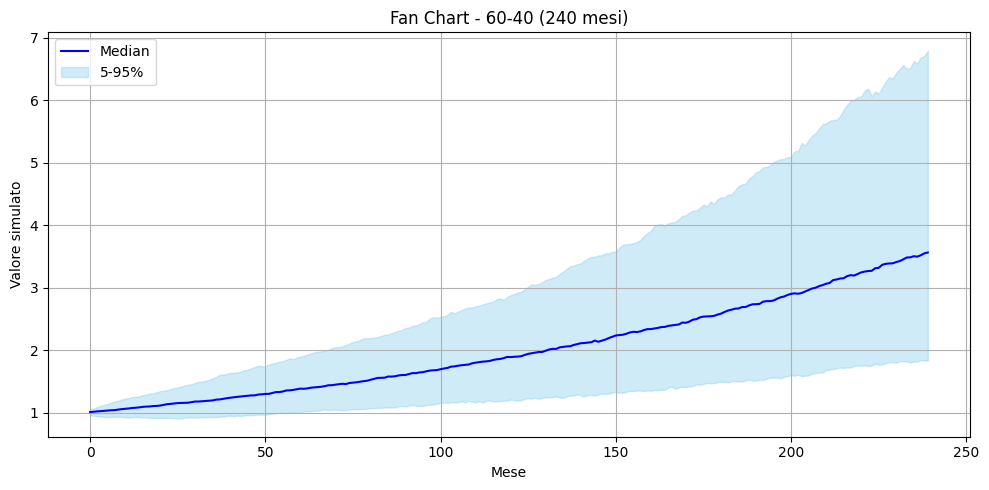

In [158]:
import matplotlib.pyplot as plt

def plot_fan_chart(sim_df, portfolio_name, horizon_months):
    """
    sim_df: una simulazione per un portafoglio e orizzonte
    """
    median = sim_df.median(axis=1)
    q05 = sim_df.quantile(0.05, axis=1)
    q95 = sim_df.quantile(0.95, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(median, label="Median", color="blue")
    plt.fill_between(sim_df.index, q05, q95, color="skyblue", alpha=0.4, label="5-95%")

    plt.title(f"Fan Chart - {portfolio_name} ({horizon_months} mesi)")
    plt.xlabel("Mese")
    plt.ylabel("Valore simulato")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fan_chart(simulations["60-40"][240], "60-40", 240)


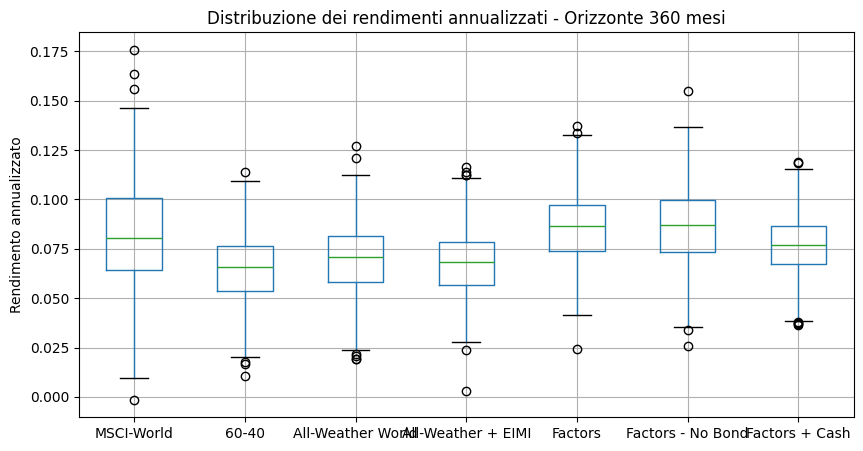

In [159]:
def plot_return_boxplot(simulations, horizon):
    data = {}

    for portfolio in simulations:
        sim_df = simulations[portfolio][horizon]
        final_vals = sim_df.iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        data[portfolio] = ann_ret

    pd.DataFrame(data).boxplot(figsize=(10, 5))
    plt.title(f"Distribuzione dei rendimenti annualizzati - Orizzonte {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.grid(True)
    plt.show()
plot_return_boxplot(simulations, 360)


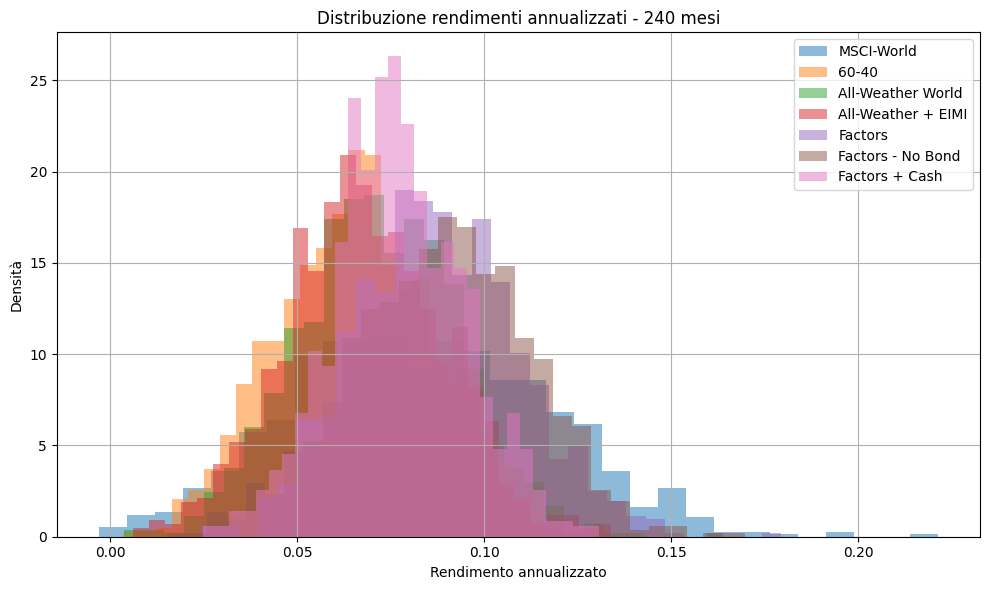

In [160]:
import matplotlib.pyplot as plt

def plot_return_hist(simulations, horizon, bins=30):
    """
    simulations: dict[portfolio][horizon] -> DataFrame simulazioni
    horizon: orizzonte in mesi es. 60
    """
    plt.figure(figsize=(10,6))
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        plt.hist(ann_ret, bins=bins, alpha=0.5, label=portfolio, density=True)

    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.xlabel("Rendimento annualizzato")
    plt.ylabel("Densità")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_return_hist(simulations, horizon=240)


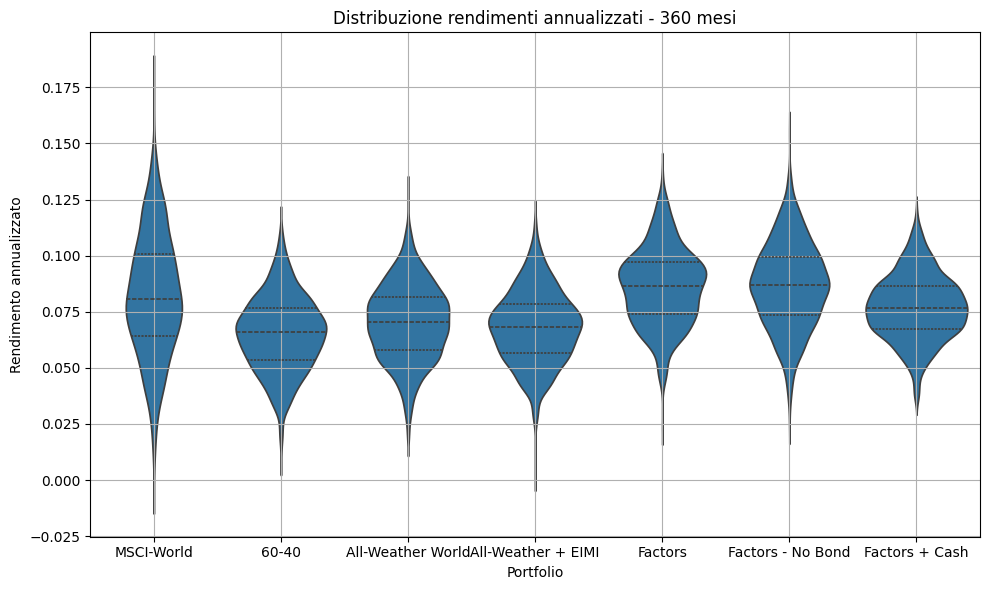

In [161]:
import seaborn as sns

def plot_return_violin(simulations, horizon):
    data = []
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        for val in ann_ret:
            data.append({"portfolio": portfolio, "return": val})
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,6))
    sns.violinplot(x='portfolio', y='return', data=df, inner="quartile")
    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.xlabel("Portfolio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_return_violin(simulations, horizon=360)

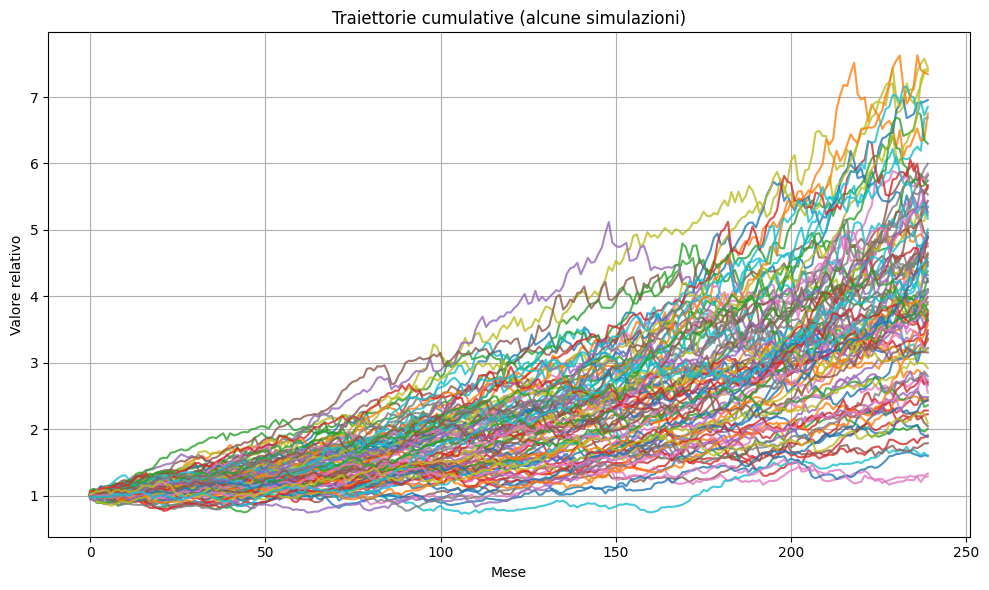

In [148]:
def plot_cumulative_paths(sim_df, num_paths=1000):
    """
    Visualizza num_paths traiettorie casuali su sim_df
    """
    sampled = sim_df.sample(n=min(num_paths, sim_df.shape[1]), axis=1)
    plt.figure(figsize=(10,6))
    for col in sampled:
        plt.plot(sampled[col], alpha=0.8)
    plt.title("Traiettorie cumulative (alcune simulazioni)")
    plt.xlabel("Mese")
    plt.ylabel("Valore relativo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_cumulative_paths(simulations["60-40"][240], num_paths=100)